**1. Import các thư viện cần thiết**

In [20]:
# 1. Các thư viện cần thiết
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error as msle

**2. Đọc file dữ liệu và chia dataset theo tỉ lệ 7:3**

In [21]:
# Đọc file dữ liệu
df = pd.read_csv('D:\CTG.csv')

df = df[['Price','Low']]
df = df.dropna() # Drop missing values
df = df.reset_index(drop=True) # Reset the index
df1 = df
# Split the data into training, testing, and validation
train_size = int(0.7 * len(df))
test_size = int(0.3 * len(df))

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]


**Xem** **lại** **dataset**

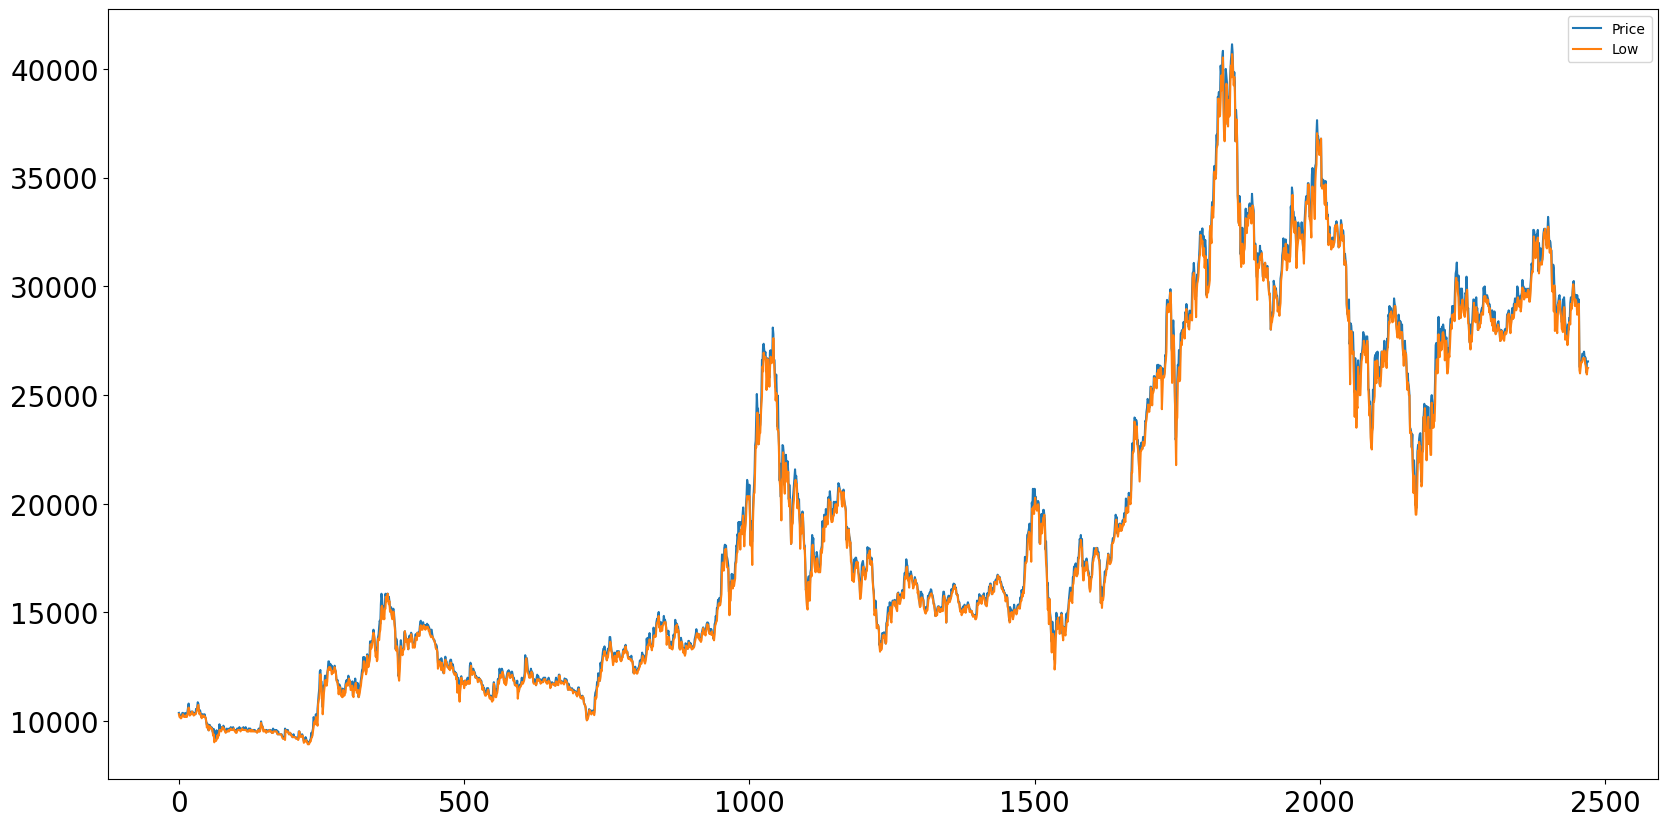

In [22]:
df.plot(figsize=(20, 10), fontsize=20)
plt.show()

***Tìm m thích hợp***

In [23]:
# Dùng adf để kiểm tra xem dataset có stationary hay chưa
from statsmodels.tsa.stattools import adfuller
adfuller(df['Price'])

(-1.4790235352046806,
 0.5438614038107454,
 1,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36992.4752760539)

In [24]:
# Vì dataset chưa stationary nên ta thực hiện diff()
df_diff = df1['Price'].diff().dropna()

In [25]:
# Tiếp tục dùng adf để kiểm tra xem p value có < 0.05 ko
adfuller(df_diff)

(-51.946172382469705,
 0.0,
 0,
 2469,
 {'1%': -3.4330013210750745,
  '5%': -2.8627113331035243,
  '10%': -2.567393547066656},
 36978.54167482712)

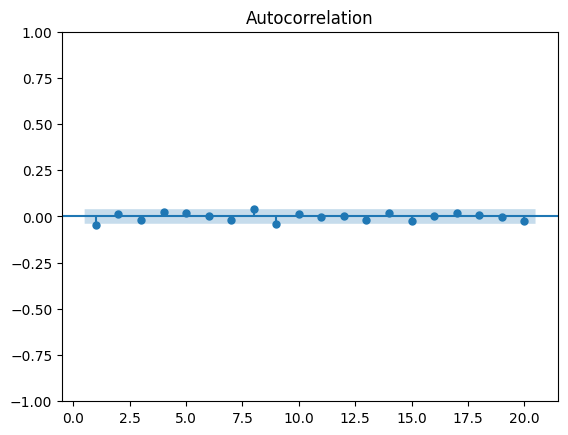

In [26]:
# Sau khi dataset đã stationary vẽ acf để tìm m
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df_diff, lags = 20 , zero = False)
plt.show()

**3. Dùng auto_arima để tìm model thích hợp**

In [27]:
df

,Price,Low
0,10379.9,10318.5
1,10318.5,10195.6
2,10257.0,10195.6
3,10195.6,10134.2
4,10195.6,10134.2
...,...,...
2466,26700.0,26350.0
2467,26050.0,26050.0
2468,26500.0,25950.0
2469,26550.0,26200.0


In [28]:
# Tạo y_train, x_train
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])
# Dùng auto_arima để tìm thông số thích hợp
from pmdarima.arima import auto_arima
model = auto_arima(y_train, trace=True, error_action='ignore', suppress_warnings=True, seasonal = True, m =5)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[5] intercept   : AIC=25101.162, Time=1.49 sec
 ARIMA(0,1,0)(0,0,0)[5] intercept   : AIC=25118.618, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[5] intercept   : AIC=25114.001, Time=0.14 sec
 ARIMA(0,1,1)(0,0,1)[5] intercept   : AIC=25115.241, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[5]             : AIC=25117.813, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[5] intercept   : AIC=25095.089, Time=0.92 sec
 ARIMA(2,1,2)(0,0,0)[5] intercept   : AIC=25093.245, Time=0.63 sec
 ARIMA(2,1,2)(1,0,0)[5] intercept   : AIC=25095.072, Time=0.97 sec
 ARIMA(1,1,2)(0,0,0)[5] intercept   : AIC=25091.832, Time=0.95 sec
 ARIMA(1,1,2)(1,0,0)[5] intercept   : AIC=25106.699, Time=0.20 sec
 ARIMA(1,1,2)(0,0,1)[5] intercept   : AIC=25106.938, Time=0.23 sec
 ARIMA(1,1,2)(1,0,1)[5] intercept   : AIC=25101.663, Time=1.37 sec
 ARIMA(0,1,2)(0,0,0)[5] intercept   : AIC=25104.495, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[5] intercept   : AIC=25089.968, Time=0.48 sec
 ARIMA(1,1,1)(1,0,0

**Dùng SARIMAX để train model**

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model1 = SARIMAX(y_train, exog = np.array(train_data['Price']), order=(1,1,1), seasonal_order=(0,0,0,5))
model_fit = model1.fit()

C:\Users\user\AppData\Roaming\Python\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**4. Quá trình test**

In [30]:
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
exg = np.array(test_data['Low'])
y_pred_test = model_fit.predict(start=len(y_train), end=len(y_test)+len(y_train)-1, exog=exg)
y_pred_test

array([26393.9, 26620.8, 26999. , 29040.9, 29116.5, 29192.2, 28814. ,
       29116.5, 29116.5, 29721.6, 29192.2, 27150.2, 25562. , 26847.7,
       27755.2, 27604. , 26091.4, 24578.9, 22952.9, 21780.7, 23822.6,
       23973.9, 25713.3, 25902.4, 26280.5, 25637.7, 25713.3, 27112.4,
       27452.7, 27301.5, 27830.9, 27982.1, 28019.9, 28019.9, 27604. ,
       28435.9, 28738.4, 28965.3, 28360.3, 28360.3, 28398.1, 28057.7,
       28019.9, 28587.1, 28700.6, 28549.3, 28473.7, 28435.9, 30402.2,
       30477.8, 30629.1, 30402.2, 29419. , 29419. , 28587.1, 29721.6,
       30137.5, 30250.9, 30477.8, 31007.2, 31385.4, 31461. , 32368.5,
       32217.3, 31990.4, 32103.8, 31763.5, 31385.4, 31763.5, 30856. ,
       31234.1, 31385.4, 29608.1, 29494.7, 29986.2, 29721.6, 29910.6,
       30061.9, 30288.8, 32784.5, 32292.9, 31990.4, 33654.2, 33427.3,
       33162.6, 33767.6, 35280.2, 35091.1, 34939.8, 35166.7, 36338.9,
       36452.4, 36754.9, 38645.6, 38418.7, 37813.7, 37889.3, 38570. ,
       39704.4, 3902

**6. Quá trình tạo index predict 30 ngày tiếp theo**

In [31]:
# Dùng thuật toán LR để tìm giá trị Low cho 30 ngày tiếp theo
from sklearn.linear_model import LinearRegression

ln_model = LinearRegression()

ln_model.fit(np.array(train_data.index).reshape(-1,1), train_data['Low'])

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)

# Dự đoán giá trị low 30 ngày tiếp theo
low_next_30_days = ln_model.predict(x_next_30_days)

# Predict the closing prices for the next 30 days
y_next_30_days = model_fit.predict(start=len(x_train), end = len(x_train)+ len(x_next_30_days)-1, exog=low_next_30_days)
# Print the predicted closing prices for the next 30 days
print('Predicted closing prices for the next 30 days:')
print(y_next_30_days)

Predicted closing prices for the next 30 days:
[23870.80551994 23876.59323014 23882.38094034 23888.16865053
 23893.95636073 23899.74407093 23905.53178112 23911.31949132
 23917.10720152 23922.89491171 23928.68262191 23934.47033211
 23940.2580423  23946.0457525  23951.83346269 23957.62117289
 23963.40888309 23969.19659328 23974.98430348 23980.77201368
 23986.55972387 23992.34743407 23998.13514427 24003.92285446
 24009.71056466 24015.49827486 24021.28598505 24027.07369525
 24032.86140545 24038.64911564]


***7.Đánh giá độ chính xác thuật toán***

In [32]:
#MSLE
test_msle = msle(y_test, y_pred_test)
print('Testing MSLE:', test_msle)

#RMSE
test_rmse = np.sqrt(np.mean((y_pred_test - y_test)**2))
print('Testing RMSE:', test_rmse)

#MAPE
test_mape = np.mean(np.abs((y_test - y_pred_test) / y_test)) * 100
print('Testing MAPE:', test_mape)

#MAE
test_mae = np.mean(np.abs(y_pred_test - y_test))
print('Testing MAE:', test_mae)

Testing MSLE: 0.00041597448240349893
Testing RMSE: 581.7979728402988
Testing MAPE: 1.3174191773236228
Testing MAE: 389.2678812415674


**8. Vẽ biểu đồ**

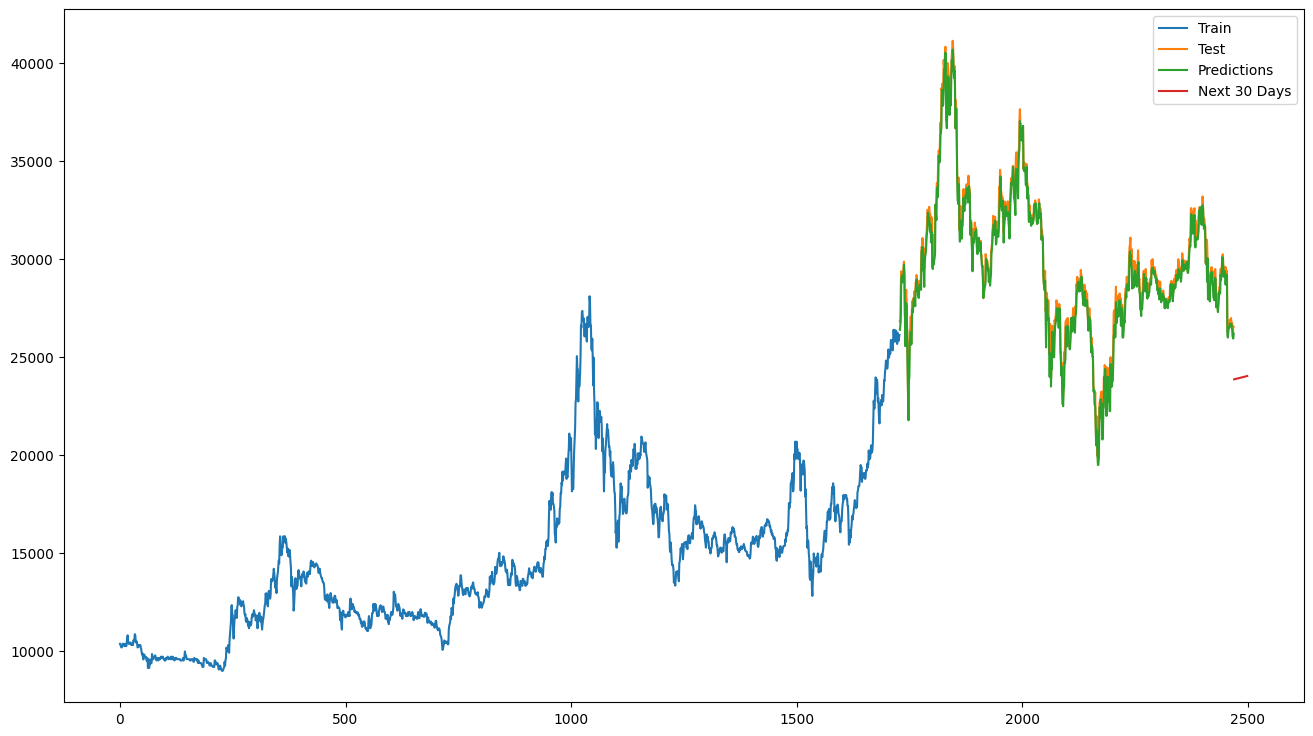

In [33]:
plt.figure(figsize=(16,9))
plt.plot(train_data.index, train_data['Price'])
plt.plot(test_data.index, test_data['Price'])
plt.plot(test_data.index, y_pred_test)
plt.plot(last_data,y_next_30_days)
plt.legend(['Train', 'Test', 'Predictions','Next 30 Days'])
plt.show()